In [4]:
import galsim 
import numpy as np
import matplotlib.pyplot as plt 

In [5]:
eta1, eta2 = 0.1 ,2
s = galsim.Shear(eta1=100, eta2=0.2)
s.e1

0.9999980000060001

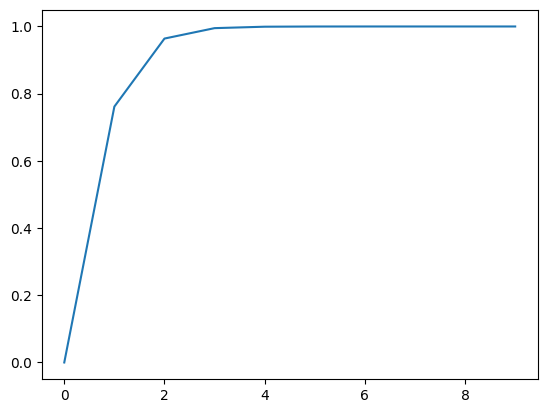

In [6]:
e1 = [galsim.Shear(eta1=x, eta2=0.0).e1 for x in np.arange(10)]
plt.plot(np.arange(10), e1)

In [7]:
etas = (np.random.rand(1000) - 0.5) * 10

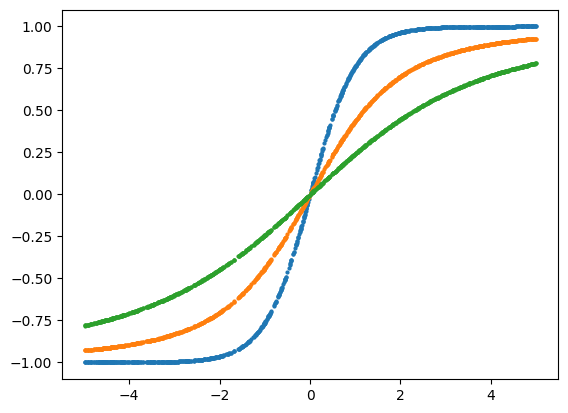

In [8]:
for y in [0, 2, 4]:
    e1s = [galsim.Shear(eta1=x, eta2=y).e1 for x in etas]
    plt.plot(etas, e1s, 'o', markersize=2)


# Transformations

In [9]:
import jax
import jax.numpy as jnp
from jax import grad, vmap

In [10]:
eta = (2, 0.5)
eta_comp = eta[0] + eta[1] * 1j
g_comp = jnp.tanh(eta_comp * 0.5)
g_comp

Array(0.78168831+0.10332941j, dtype=complex128, weak_type=True)

In [11]:
# def eta2g(eta):
#     assert eta.shape == (2,)
#     eta_comp = eta[0] + eta[1] * 1j
#     g_comp = jnp.tanh(eta_comp * 0.5)
#     return jnp.array([g_comp.real, g_comp.imag])

In [12]:
def eta2g(eta):
    assert eta.shape == (2,)
    eta1 = eta[0]
    eta2 = eta[1]
    abseta = jnp.sqrt(eta1**2 + eta2**2)
    g1 = eta1 * jnp.tanh(0.5 * abseta) / abseta
    g2 = eta2 * jnp.tanh(0.5 * abseta) / abseta
    return jnp.array([g1, g2])

In [13]:
def g2eta(g):
    assert g.shape == (2,)
    g1 = g[0]
    g2 = g[1]
    absg = jnp.sqrt(g1**2 + g2**2)
    eta1 = g1 * jnp.arctanh(absg) * 2 / absg
    eta2 = g2 * jnp.arctanh(absg) * 2 / absg
    return jnp.array([eta1, eta2])

In [14]:
eta = jnp.array([1,2])
s = galsim.Shear(eta1=1, eta2=2)
eta2g(eta), s.g1, s.g2

(Array([0.36084949, 0.72169898], dtype=float64),
 0.3608494892040599,
 0.7216989784081198)

In [15]:
g2eta(eta2g(eta))

Array([1., 2.], dtype=float64)

In [16]:
gs = jnp.array([[0.2, 0.4]])

In [17]:
vmap(g2eta)(gs)

Array([[0.43040894, 0.86081788]], dtype=float64)

In [18]:
# gradients 

eta_inv_fnc1 = lambda g: g2eta(g)[0]
eta_inv_fnc2 = lambda g: g2eta(g)[1]

In [19]:
grad(eta_inv_fnc1)(gs[0])

Array([2.22163576, 0.13918212], dtype=float64)

In [20]:
vmap(grad(eta_inv_fnc1))(gs)

Array([[2.22163576, 0.13918212]], dtype=float64)

# Generate (noisy) samples 

In [21]:
from bpd.sample import sample_ellip_prior
from bpd.shear import shear_transformation

In [22]:
k = jax.random.key(52)

In [23]:
es = sample_ellip_prior(k, sigma=1., n=10)
es.shape

(10, 2)

In [24]:
es

Array([[ 0.30901353, -0.13903061],
       [ 0.36031969, -0.0461676 ],
       [ 0.44666394, -0.26755364],
       [ 0.42915883,  0.2710007 ],
       [-0.26980508, -0.68345618],
       [ 0.12889292,  0.23412989],
       [ 0.18267073,  0.34250431],
       [ 0.18203203, -0.2801691 ],
       [ 0.14407943, -0.23815493],
       [-0.44126099,  0.36904614]], dtype=float64)

In [25]:
vmap(g2eta)(es)

Array([[ 0.64345715, -0.28950266],
       [ 0.75511195, -0.09675216],
       [ 0.99041677, -0.59326394],
       [ 0.94604667,  0.5973996 ],
       [-0.68961636, -1.74690026],
       [ 0.264201  ,  0.47991273],
       [ 0.38555244,  0.72290384],
       [ 0.37859755, -0.58270696],
       [ 0.29596703, -0.48921632],
       [-1.00538059,  0.84084439]], dtype=float64)

In [26]:
def sample_noisy_eta(rng_key, *, g, sigma_e:float, sigma_m:float, n:int=1):
    k1, k2 = jax.random.split(rng_key)
    es = sample_ellip_prior(k1, sigma_e, n)
    essh = shear_transformation(es, g)
    etas = vmap(g2eta)(essh)
    noisy_etas = etas.reshape(n, 2) + jax.random.normal(k2, shape=(n, 2)) * sigma_m
    return noisy_etas, etas
    
    

In [27]:
netas, etas = sample_noisy_eta(k, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=100_000)

In [28]:
etas.shape

(100000, 2)

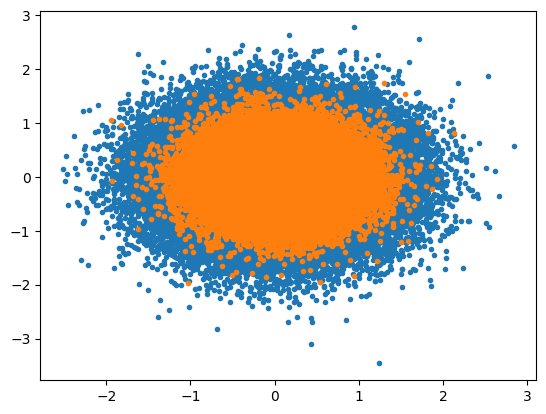

In [29]:
plt.plot(netas[:, 0], netas[:, 1], 'o', markersize=3)
plt.plot(etas[:, 0], etas[:, 1], 'o', markersize=3)

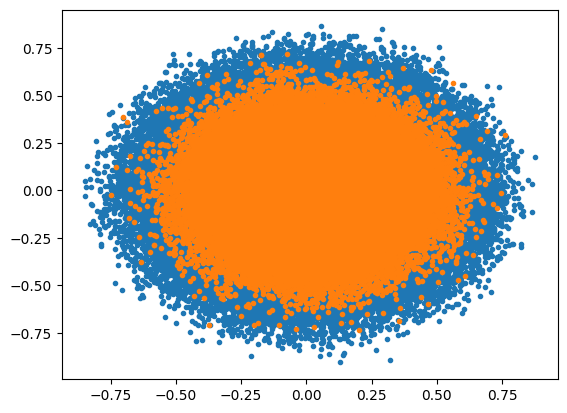

In [30]:
nes = vmap(eta2g)(netas)
es = vmap(eta2g)(etas)
plt.plot(nes[:, 0], nes[:, 1], 'o', markersize=3)
plt.plot(es[:, 0], es[:, 1], 'o', markersize=3)

In [31]:
nes[:, 0].mean(), es[:, 0].mean()

(Array(0.0167261, dtype=float64), Array(0.01940866, dtype=float64))

## Validation

In [32]:
from bpd.sample import sample_ellip_prior

In [33]:
n = 10000000

In [34]:
netas, etas = sample_noisy_eta(k, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=n)
es_eta = vmap(eta2g)(etas)
nes_eta = vmap(eta2g)(netas)
es_eta[:, 0].mean(), nes_eta[:, 0].mean()

(Array(0.01997347, dtype=float64), Array(0.01862445, dtype=float64))

In [35]:
k1, k2 = jax.random.split(k)
es = sample_ellip_prior(k1, sigma=0.2, n=10000000)
essh = shear_transformation(es, jnp.array([0.02, 0.0]))
essh[:, 0].mean()

Array(0.01997347, dtype=float64)

# Likelihood

In [52]:
from bpd.prior import ellip_prior_e1e2
from jax.scipy.stats import norm
from jax import grad 

eta_inv_fnc1 = lambda eta: eta2g(eta)[0]
eta_inv_fnc2 = lambda eta: eta2g(eta)[1]

grad_fnc1 = grad(eta_inv_fnc1)
grad_fnc2 = grad(eta_inv_fnc2)


def eta_target(eta, *, data, sigma_e:float, sigma_m:float):
    neta = data
    llike = norm.logpdf(neta, loc=eta, scale=sigma_m).sum()

    e1e2 = eta2g(eta)
    lprior1 = jnp.log(ellip_prior_e1e2(e1e2, sigma_e))

    grad1 = grad_fnc1(eta)
    grad2 = grad_fnc2(eta)
    prior2 = jnp.abs(grad1[...,0] * grad2[...,1] - grad1[...,1] * grad2[...,0])
    lprior2 = jnp.log(prior2)

    return llike + lprior1 + lprior2

In [56]:
eta_target(etas[0], data=netas[0], sigma_e=0.2, sigma_m=0.5)

Array(-3.53450562, dtype=float64)

# Run infrence

In [63]:
from bpd.chains import run_inference_nuts
from jax import random 

from functools import partial

In [64]:
k1, k2 = random.split(random.key(42))

In [65]:
n = 10_000
netas, etas = sample_noisy_eta(k1, g = jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.5, n=n)
netas.shape, etas.shape

((10000, 2), (10000, 2))

In [70]:
k2s = random.split(k2, (n,))
k2s.shape

(10000,)

In [71]:
target = partial(eta_target, sigma_e=0.2, sigma_m=0.5)

pipe = partial(run_inference_nuts, logtarget=target, n_samples=1000, initial_step_size=0.01, max_num_doublings=2)

In [73]:
samples = vmap(pipe)(k2s, netas, etas)

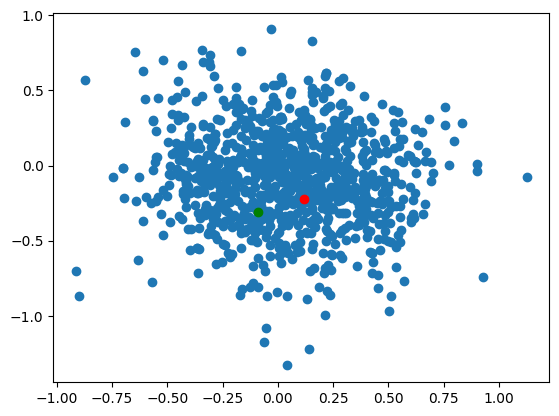

In [79]:
plt.plot(samples[0, :, 0], samples[0, :, 1], 'o')
plt.plot(netas[0, 0], netas[0, 1], 'ro')
plt.plot(etas[0,0], etas[0, 1], 'go')